<div hidden>
\newcommand{\require}[1]{}

$\require{begingroup}\require{newcommand}$
$$
   \gdef\RR{{\bf R}}
   \gdef\us{{\bf u_s}}
   \gdef\ue{{\bf u_e}}
   \gdef\ui{{\bf u_i}}
   \gdef\II{{\bf I}}
   \gdef\EE{{\bf E}}
   \gdef\BB{{\bf B}}
   \gdef\VV{{\bf V}}
   \gdef\JJ{{\bf J}}
   \gdef\PT{{{\overleftrightarrow{\bf P}}}_e}
   \newcommand{\p[2]}{\frac{\partial #1}{\partial #2}}
$$

</div>

# Motivation
In this module we will discuss current computational methods to modeling plasmas. In particular, we will simulate an ubiquitous phenomena in laboratory, space, and astrophysical plasmas called magnetic reconnection. Additionally, in this module we will introduce a broad array of skills useful in computational physics which you may not have seen before: Git version control, shell commands, post-processing simulation data using Python. A variety of plasma models will be employed which span the space of both fidelity and computational complexity, from first-principles kinetic modeling to approximate fluid models like magnetohydrodynamics. We will aim to properly introduce these vital skills to students, taking care to cater to various levels of prior knowledge.
(**figures demonstrating high performance computing**) 

The file you are viewing is called a Jupyter Notebook, it is a cell based multiplatform file that can host live code from different languages, TeX equations, multimedia and text all in one file. All of the former options can be run in a cell with SHIFT+ENTER. If you have joined here from the Github README, go to the setup procedure for your respective operating system - [Windows](#Setup-Procedure---Windows) or [macOS](#Setup-Procedure---macOS). If you are using the former, the procedure will take you through creating a linux virtual machine and installing this notebook file and the rest of the folder in that virtual machine. If you are using Macos, you likely have this repository downloaded, so the setup procedure will be shorter.

Jupyter Lab automatically creates a Table of contents that you can access by clicking this icon on the sidebar  <img src="./assets/toc.png" style="width:20px"> to navigate the notebook. Remember to look at the README file as well for a overview of the repository and files contained.

# Background
## An overview of magnetic reconnection
Magnetic reconnection is a process in which the magnetic topology is rearranged in the presence of a plasma. This topological rearrangement of the field lines is a mechanism of converting magnetic field energy to other forms of energy: heat, large scale plasma flows, and accelerating particles to very high energies. It is easiest to visualize this process with a pair of oppositely directed (antiparallel) magnetic field lines in a system that experiences high heat levels. One can think of the magnetic field lines snapping and "reconnecting" with other field lines in complete analogy with a rubber band snapping (*see the gif below*).  Common examples of this are coronal mass ejections and when the solar wind impacts the Earth's magnetosphere. Magnetic field lines have inherent tension, which act to straighten out magnetic field lines. When reconnection occurs, this force acts towards the center of curvature and pushes the plasma out, similar to a slingshot. We will discuss the source of tension later, but first we will find out what, mathematically, causes this process.
<figure>
<img src="./assets/Reconnection.gif" style="width:50%">
<figcaption align = "center"> Source: By ChamouJacoN - Own work, Public Domain, https://commons.wikimedia.org/w/index.php?curid=7496329 </figcaption>
</figure>

## A deeper dive into magnetic reconnection
We first start with the ideal Ohms Law equation for ideal non-resistive magnetohydrodynamic models $$ \EE+\VV\times\BB=0 $$ which describe systems that follow the frozen in theorem. The theorem states that without any resistivity in a fluid, the magnetic field is frozen in to said fluid. In a plasma this means that the magnetic field lines move with the plasma. Furthermore, the field will not change when moving along with the field lines, but motions transverse to the field carry the field with the motion. 

We can derive the frozen-in theorem by taking Ohm's Law and applying it to Faraday's Law, getting $$ \frac{\partial\BB}{\partial t} = \nabla \times (\VV \times \BB) - c\nabla \times (\eta \JJ) $$ since the current density J is proportional to $\nabla\times\BB$ through Ampere's Law, we arrive at $$ \frac{\partial\BB}{\partial t} = \nabla \times (\VV \times \BB) + c\eta (\nabla^2 \JJ) $$ after some simplifications, namely using the curl of a curl identity and that $\nabla \cdot B=0$ since there are no magnetic monopoles.

Since $\eta = \frac{1}{\mu_0 \sigma}$, where $\mu_0$ is the permiability of free space as $\sigma$ is the electrical conductivity, when we look no resistivity/infinite conductivity, the $\eta$ term in the magnetic field equation falls out and we are left with the induction equation.

With the induction equation $$ \frac{\partial\BB}{\partial t} = \nabla \times (\VV\times\BB) $$ we use $\Phi = \int_s{\BB\cdot dS}$ to get $$ \frac{\mathrm{d}\Phi}{\mathrm{d}t}=\frac{\mathrm{d}}{\mathrm{d}t}\int_s{\BB \cdot dS}$$ 
The two ways the magnetic flux can change is through a change in the magnetic field strength $\frac{\partial B}{\partial t}$ or a movement in the surface we integrate over. We can substitute the induction equation in for the first term and get $$ \int_s{\nabla\times(\VV\times \BB)\cdot ds}+\int_s{\BB\cdot (\VV\times d\ell)} $$ The second term arises from movement on the surface of integration. We can use Stokes' Theorem and the vector identity $(A\times B)\cdot C = -B\cdot (A\times C)$ to get $$ \int_c{\VV\times \BB\cdot d\ell}-\int_c{(\VV\times \BB)\cdot d\ell} = 0 $$ 
Thus, we find that $\frac{d}{dt}\int_s{\BB\cdot ds}=0$, proving the frozen in theorem when we have no resistivity. 

When we introduce resistivity, Ohm's Law transforms into $$ \EE+\VV\times \BB=\eta \JJ $$ where $\eta$ is the magnetic diffusivity, and the system no longer follows the frozen in theorem. This means that the magnetic field lines are no longer frozen to the plasma and can reconnect. 

## Modeling magnetic reconnection
In order to talk about the models we must find all the physical properties to consider when generating a model and any approximations. First we start with the electron momentum equation for the ith component of the electric field $$ m\frac{\partial n\ue}{\partial t}+\nabla\cdot\overleftrightarrow{\mathcal P} = nq(\EE+\ue\times\BB) $$ our goal is to end up with the generalized Ohm's Law equation which will play a key role in the future. In order to get there, we rearrange the electron momentum equation to get $E=\frac{m}{nq}\frac{\partial n\ue}{\partial t}+\nabla\cdot\overleftrightarrow{\mathcal P}-\ue\times\BB$.  The u in the term is electron flow, so we can subsitute in $$ \ue=-\frac{\JJ}{q_sn_s}+\ui$$ where J is current density and $\ui$ is ion flow. With this information we get $$-\ue\times\BB=(\frac{\JJ}{q_sn_s}-\ui)\times\BB=\frac{\JJ\times \BB}{q_sn_s}-\ui\times \BB$$

For the $\overleftrightarrow{\mathcal P}$ (stress tensor) term, we can substitute in the equation of the tensor involving reynolds stress $$\overleftrightarrow{\mathcal P}=\PT+\rho \ue\ue$$ Now we are left with $$E+\ui\times \BB=\frac{\JJ\times \BB}{nq}+\frac{1}{nq}\frac{\partial nm\ue}{\partial t}+\frac{\nabla\cdot\PT}{nq}+\frac{\nabla\cdot nm\ue\ue}{nq}$$ 

We can combine the time derivative of momentum and divergence of Reynolds stress using product rule, so $$\frac{\partial nm\ue}{\partial t}=nm\frac{\partial\ue}{\partial t} + \ue\frac{\partial nm}{\partial t}$$ $$\nabla\cdot (nm\ue\ue) = \ue\nabla\cdot(nm\ue)+nm\ue\cdot\nabla\ue$$ Resulting in $$nm(\frac{\partial \ue}{\partial t}+\ue\cdot\nabla \ue)+\ue(\frac{\partial nm}{\partial t}+\nabla\cdot (nm\ue))=nm(\frac{\partial \ue}{\partial t}+\ue\cdot\nabla \ue)$$ since the second term equals 0 due to mass conservation $\frac{\partial\rho}{\partial t}+\nabla\cdot (\rho u) = 0$. 
Now we can switch back to vector notation to look at the electric field as a whole and plug in our new expression for the electron inertia contribution, arriving at $$ \EE+\ui\times \BB=\eta \JJ+\frac{\JJ\times \BB}{nq}-\frac{\nabla \cdot \PT}{nq}+\frac{m}{q}[(\frac{\partial \ue}{\partial t}+\ue\cdot\nabla\ue)] $$
where the left hand side comes from the ideal MHD, the $\eta J$, $J\times B$, and $P_e$ terms are known as the resistive dissipation, hall and the pressure tensor terms, respectively.
(**Expand on tension**)
### 5 moment models
In this computational demo we will start with the 5 moment simulation, which symplifies the pressure tensor down to a scalar. This is Eulers equations shown below, where the force is Lorentz force $$ \frac{\partial\rho}{\partial t}+\nabla\cdot (\rho\us) = 0 $$ 
$$ \frac{\partial\rho\us}{\partial t}+\nabla\cdot (\rho\us\us+p_s\II) = q_sn_s (\EE+\us\times\BB)$$ 
$$ \frac{\partial\mathcal{E}_s}{\partial t}+\nabla\cdot([\mathcal{E}_s+p]\us)=q_sn_s\us\cdot\EE $$ 
$$ \mathcal{E}_s=\frac{1}{2}\rho_s|\us|^2+\frac{p_s}{\gamma-1} $$ 
These equations represent the conservation of mass, momentum and energy, respectively, where the total energy is $\mathcal{E}_s$ and the adiabatic index of an ideal fluid $\gamma$ is 5/3 for hydrogen plasma. 
Then we will expand the tensor out and compute the 10 moment simulation. Normally, only including the resistive dissipation term causes reconnection to occur far too slowly to only be attributed to the physics. But the hall term and the divergence of the pressure tensor causes the simulations to reconnect much more faster, closer to real life phenomenon. The hall term alone causes the reconnection rate to be comparable to the Alfvén speed, while "at small values of resistivity the dissipation region forms an elongated Sweet-Parker layer and the rate of reconnection is very low, with an inflow velocity $v_i$ into the X line which scales like $v_i=\frac{\delta}{\Delta}v_A<<v_A$, where $\delta$ and $\Delta$ are the width (controlled by resistivity) and length (macroscopic) of the dissipation region, respectively, and $v_A$ is the Alfven velocity" [Birn et al., 2001] as illustrated by the GEM reconnection challenge results.

As mentioned before, 5 moment models simplify the pressure tensor down to a scalar. The 5 moment model is in fact a generalization of the Hall-MHD model (taking Ohm's law until the hall term) which can be found from the 5 moment model by approximating the speed of light to be infinite. By simplifying the pressure tensor, the 5 moment model is significantly easier to run, but can be an inaccurate model outside of the reconnection zone.


# Setup Procedure - Windows
## Install WSL 2 
- follow directions on https://gkeyll.readthedocs.io/en/latest/install.html#note-on-the-windows-linux-subsystem-wsl (Ubuntu installation preferred, the following instructions may not work on other distributions)
- If installing CUDA, use https://docs.nvidia.com/cuda/wsl-user-guide/index.html#cuda-support-for-wsl2
- Install common libraries with ```sudo apt install build-essential```
- Run 
```bash
sudo apt update
sudo apt upgrade
sudo apt autoremove
```
- When using Gkeyll and Jupyter Lab in the future, open the ubuntu application from windows, or type "ubuntu" in another terminal application
    - Using windows terminal to do both of these is recommended for tabs, themes and easy configuration

## Install Conda 
- (Recommended) If you want to run Jupyter Lab in WSL 2 on your local machine's browser, install a conda distribution if you do not have one
    - Either install Miniconda (lightweight, easier installation) or Anaconda (far more packages, useful if you also need more features for other applications)
        - Miniconda: first download the installer with the command 
        ```bash
        wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
        sudo chmod +x Miniconda3-latest-Linux-x86_64.sh
        ./Miniconda3-latest-Linux-x86_64.sh
        ``` 
        and follow the prompts. When you have installed Miniconda correctly, jump to [Install Jupyter Lab](##Install-Jupyter-Lab) below.
        - Anaconda: follow https://docs.anaconda.com/anaconda/install/linux/ up to step 9 and jump to [Install Jupyter Lab](##Install-Jupyter-Lab) below.
- If you want to install the standalone application, follow directions on https://github.com/jupyterlab/jupyterlab-desktop#download, then jump to "Add WSL 2 terminal in JL"


## Install Jupyter Lab
- First, either open a new terminal or run ```source ~/.bashrc```, then activate conda with ```conda activate``` 
- Then update conda with,
```bash
conda update conda
conda update --all
```
- Create a new conda virtual environment with `conda create --name [NAME] python=3.8` with a name of your choice. If you choose to do this, you must also run `conda activate [NAME]` with the same name as before if you want to use anything you will install in the next steps. If you create the virtual environment correctly, you should see **[NAME]** text before the terminal prompt like this <img src="./assets/conda.png" style="width:20%"> Avoid using a newer python version than 3.8 due to compatability issues.
- Then install Jupyter Lab and dependencies with 
```bash
conda install matplotlib jupyter jupyterlab pip git
conda install -c conda-forge jupyter_contrib_nbextensions
conda update --all
```
- Clone this repository on your machine with `git clone https://github.com/KasaiYuki/gkylnotebooks.git`
- Then launch Jupyter Lab by entering `jupyter lab --no-browser` in the terminal, and copying one of the URLs listed at the end of the output into a browser on your *local* machine, and navigate to the "gkylnotebooks" folder and open this file. It will look something like this.  
<figure>
<img src="./assets/JL-Example.png" style="width:100%">
<figcaption align = "center"> Example appearance </figcaption>
</figure>
This is the recommended layout, with the notebook and terminal open side by side since not everything can be done directly on the notebook. Now that we have this notebook on the virtual machine, we run the rest of the commands from within the notebook. Any cell that starts with "%%bash" or a line that starts with "!" indicates shell commands similar to the ones that let you install packages before. Run these commands as usual, or if you prefer, copy them into a terminal of your choice (without those characters).


## Installing and compiling GkeyllZero
- Clone GkeyllZero the folder you want the repository to be in using the command below (for best performance use something in /home/USER_NAME/..., **NOT** /mnt/...) 

In [ ]:
!git clone https://github.com/ammarhakim/gkylzero.git

- Then, install the two main dependencies that G0 needs: cmake and gfortran
    - cmake: follow instructions in https://apt.kitware.com/ and after run the command below`
    - gfortran: if you don't have gfortran installed with "build-essential", run `sudo apt install gfortran`
- Navigate to the gkylzero directory and follow instructions in the G0 README file at https://github.com/ammarhakim/gkylzero, starting from the "Building on your machine" section

## Installing Postgkyl
- Follow the instructions at https://gkeyll.readthedocs.io/en/latest/install.html#installing-with-conda-preferred-for-non-developers, make sure that you are in the same conda environment you used previously
- When using WSL 2 on Windows 10, by default GUI is not supported. In order to be able to view the pgkyl output plots, install VcXrv (recommended), or Xming if not possible. Follow the instructions at https://gkeyll.readthedocs.io/en/latest/install.html#additional-steps-required-on-windows-10
    - Then, install xterm on WSL by entering `sudo apt install xterm`
    - Whenever you need the GUI in the future, open XLaunch first and disable access control, the XLaunch icon should appear in the icon tray

## Installing Luajit
- Normally, GkeyllZero uses C code to run the simulations, but in this module we will be using lua wrappers for the sake of more efficiently teaching the process. In order to run lua scripts we need to install Luajit.
    - First clone the fully featured Gkeyll version 2 on your machine (WSL if using windows), then run the make dependencies shell file and configure to install only luajit

In [ ]:
import os
%cd /home/kasaiyuki # Edit path to home directory
!ls
!git clone https://github.com/ammarhakim/gkyl # Clone the repository in the home directory
os.chdir('/home/kasaiyuki/gkyl/install-deps') # Edit path to the 'install-deps' folder
!ls
!./mkdeps.sh --build-adios=no --build-luajit=yes --build-eigen=no # Install only the Luajit package

- Now we need to add the Gkeyll lua files to the PATH.  For WSL users, can be done on the bash prompt by editing the .bashrc file (click on "view" on the top tool bar, then click "show hidden items" and find the file in the file browser), and adding `export LUA_PATH="$HOME/gkylsoft/gkylzero/lib/?.lua;;` towards the end of the file. A similar method can be done on different shells as well.
- (Recommended) create an alias/shortcut to use luajit without typing the full path to the executable.
    - In the .bashrc file, add the line `alias run_lua='~/gkylsoft/luajit/bin/luajit'` if you installed luajit to the default directory. 
- Then, restart the terminal with `source ~/.bashrc`. Now, whenever you need to run a lua script, just type `run_lua file.lua`, instead of the full path.

# Setup Procedure - macOS

# Running a 5 moment model
We will first start by going through a brief demo of running simulations and viewing outputs. In the 5 moment folder of this repository is a premade lua script to run a 5 moment simulation.
- Navigate to this folder and use the luajit alias to run the simulation below: `run_lua rt-5m-gem.lua` for example.

In [ ]:
%cd /home/kasaiyuki/gkylnotebooks/5-moment
!~/gkylsoft/luajit/bin/luajit rt-5m-gem.lua

- After the simulation is done, you will see in the terminal (**add terminal image**) and new output files will appear in the folder.
# Plotting Initial Conditions
The output of the fluid models will have multiple sets of files based on the lua instructions, each with a different file name ending (and then a number). The file used in this demo outputs the electron fluid moments end in "elc", ion fluid moments end in "ion", and electromagnetic field files end in "field". The number after the suffix corresponds to the frame the file contains. The number of frames is also determined by a variable in the input file called `nFrame`. First we will start by plotting the initial conditions (files ending in "0") using postgkyl. 
- First make sure you are in the correct conda environment(and if using WSL, that XLaunch is open)
- In that folder, type 
```bash
pgkyl rt-5m-gem-field_0.gkyl rt-5m-gem-elc_0.gkyl rt-5m-gem-ion_0.g
kyl select -c 3 plot --fix-aspect -f0 --subplots
```
    - The `select -c 3` flag outputs only the z axis plots, while `-f0 --subplots` collates all three plots into multiple subplots, instead of 3 different windows.
    - Explore the pgkyl documentation at https://gkeyll.readthedocs.io/en/latest/postgkyl/main.html and experiment with different plots

In [ ]:
# Used to save to a file and open inside of Jupyter, does not require XLaunch
%cd /home/kasaiyuki/gkylnotebooks/5-moment
!pgkyl rt-5m-gem-field_0.gkyl rt-5m-gem-elc_0.gkyl rt-5m-gem-ion_0.gkyl select -c 3 plot --fix-aspect -f0 --subplots --saveas '5m-init1.png'

(**Emphasize why these initial conditions are unstable to magnetic reconnection**)
With the command above, we plotted $\rho uz$ for the electron and ion fluid moments, and the x component of magnetic field, since that drives reconnection. Now that we briefly showed how to view output through the command line, lets take a look at creating python scripts to do the postprocessing. We will be using a tool (**Cite Jason**) called pgkylFrontEnd to do so. First, clone the repository below.

In [ ]:
%cd /home/USERNAME
!git clone https://github.com/jtenbarg/pgkylFrontEnd.git
%cd /home/USERNAME/gkylnotebooks/

Then we import the neccessary modules and set up the file paths and variables. 

First, copy the data files from the 5-moment folder to pgkylFrontEnd and edit the file paths below for your situation.

In [ ]:
import numpy as np
# Moves the folder to look for modules in
%cd /home/kasaiyuki/pgkylFrontEnd/ 
from utils import gkData
import matplotlib.pyplot as plt
# import scipy as sp
params = {} # Initialize dictionary to store plotting and other parameters

# Tested to handle g0 and g2: VM, 5M, 10M
# Requires a _params.txt file in your data directory of the form gkeyllOutputBasename_params.txt! See example_params.txt for formatting

paramsFile = '/home/kasaiyuki/pgkylFrontEnd/rt-5m-gem-params.txt'
fileNum = 5 # Controls which frame we are plotting - 0 is the initial conditions files
suffix = '.gkyl'
varids = ['bx', 'n_elc', 'uz_elc', 'n_ion', 'uz_ion']
nFrame = 5 # Number of frames used in the generating file - corresponds to number of output file sets made
dpsi = [0] * nFrame # Created "empty" list
data = []

/home/kasaiyuki/pgkylFrontEnd


In [ ]:
%%capture
# discards output for this cell
# Read files for the magnetic field
for i in range(len(varids)):
    varid = varids[i]
    var = gkData.gkData(paramsFile,fileNum,suffix,varid,params)
    var.readData()
    data.append(var.data)
    coords = var.coords
    print(np.shape(data))


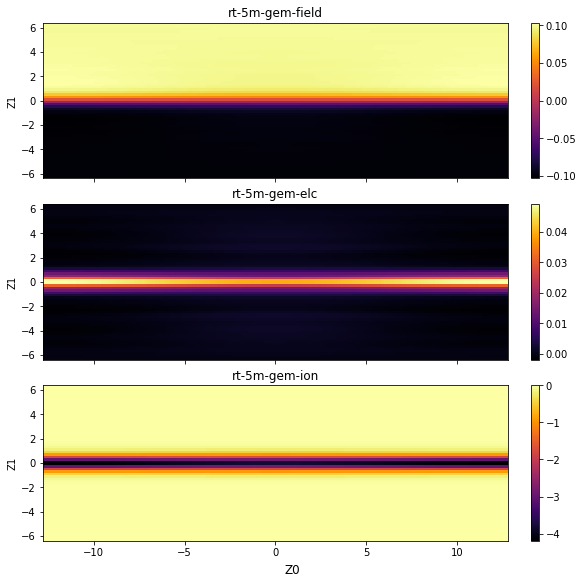

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(8, 8), constrained_layout=True, sharex=True, sharey=True)
fig.supxlabel('Z0')

# Plotting x component of magnetic field
#im1 = axes[0].imshow(np.rot90(-1*data[0]), interpolation='none', origin='lower',
#                     extent=[coords[0][0], coords[0][-1], coords[-1][0], coords[-1][-1]], cmap='gnuplot')
im1 = axes[0].pcolormesh(coords[0], coords[1], np.transpose(data[0]), cmap='inferno')
axes[0].set_ylabel("Z1")
axes[0].set_title("rt-5m-gem-field")
cbar = fig.colorbar(im1, ax=axes[0])

# Plotting electron fluid moment in z axis
im2 = axes[1].pcolormesh(coords[0], coords[1], np.transpose(data[1]*data[2]), cmap='inferno') 
axes[1].set_ylabel("Z1")
axes[1].set_title("rt-5m-gem-elc")
cbar = fig.colorbar(im2, ax=axes[1])

# Plotting ion fluid moment in z axis
mass = 25 # multiply by mass when plotting
im3 = axes[2].pcolormesh(coords[0], coords[1], np.transpose(data[3]*data[4]*mass), cmap='inferno') 
axes[2].set_ylabel("Z1")
axes[2].set_title("rt-5m-gem-ion")
cbar = fig.colorbar(im3, ax=axes[2])

plt.show()

Note that it took us much longer to get to a similar looking plot, but we also have much more power over size, colors, titles, etc. Also, editing the code to plot different frames is as easy as changing the value of the 'nFrame' variable. Now that we have gone over an example, lets move on to plotting reconnecting fluxes in the 'fluxPlotNotebook' file. 

Add WSL 2 terminal in JL\
Run ```jupyter-lab --generate-config```
Open generated file and add 
```c.NotebookApp.terminado_settings = {
    'shell_command': ['C:\\Users\\d3mon\\AppData\\Local\\Microsoft\\WindowsApps\\ubuntu.exe']
}``` to the end (change path) and restart JL

Install JL in WSL2\
https://towardsdatascience.com/configuring-jupyter-notebook-in-windows-subsystem-linux-wsl2-c757893e9d69 \
JL Kernels\
https://kegui.medium.com/how-to-add-conda-environment-to-jupyter-lab-step-by-step-431cd2c47708


# Troubleshooting
- https://stackoverflow.com/questions/66744219/jupyter-lab-networkerror-running-on-wsl2
- If when typing xterm, you get an error similar to `xterm: Xt error: Can't open display: 192.168.128.1:0`, replace the `export display` line in the .bashrc (or equivalent) file with `export DISPLAY=$(route.exe print | grep 0.0.0.0 | head -1 | awk '{print $4}'):0.0`
- If there seems to be no solution to any bugs and errors, try installing an older version of Ubuntu. Check your version by running `lsb_release -a` in the terminal and install an older LTS version from the Microsoft Store.

In [ ]:
!jupyter nbconvert --to html Reconnection-Intro.ipynb